# Custom Chatbot: 2024 Events in Spain

This notebook shows how to build a basic Question-Answering chatbot based on the [Retrieval-Augmented Generation (RAG)](https://en.wikipedia.org/wiki/Retrieval-augmented_generation) pattern.

RAG consists in 

- retrieving relevant documents related to the user **query** 
- and feeding them to a generative model in the context along with the query; 
- finally, we instruct the model to provide the answer using the provided documents/context.

Therefore, we avoid needing to fine-tune the generative model with our documents.
This is specially well suited when we want to extend the model's *memory* with recent and continuously changing documents.

In order to show how the approach works,

- I use the **model** [`gpt-3.5-turbo-instruct`](https://platform.openai.com/docs/models/gpt-3.5-turbo?snapshot=gpt-3.5-turbo-instruct) from OpenAI
- and a **dataset** or set **queried documents** built from the Wikipedia article [2024 Events in Spain](https://en.wikipedia.org/wiki/2024_in_Spain) (54 events in total).

The [`gpt-3.5-turbo-instruct`](https://platform.openai.com/docs/models/gpt-3.5-turbo?snapshot=gpt-3.5-turbo-instruct) model

- is a Legacy GPT model for cheaper chat and non-chat tasks,
- has a context window of `4,096` tokens,
- and has a **knowledge cutoff as of Sep 01, 2021**.

Therefore, we can be sure that none of the 2024 events in Spain were used for during the model training. Therefore,

- if we ask the model a question about the dataset, it should hallucinate and/or fail to answer properly;
- but if we use the RAG pattern, it should be able to build and use a relevant context that facilitates a correct answer.

**Table of Contents**:

- [Data Wrangling](#data-wrangling)
  - [Get the Data](#get-the-data)
  - [Extend the Data with Referenced Content](#extend-the-data-with-referenced-content)
  - [Persist the Data as JSONL](#persist-the-data-as-jsonl)
  - [Create the Dataframe with the Embeddings](#create-the-dataframe-with-the-embeddings)
- [Relevant Data Retrieval](#relevant-data-retrieval)
- [Custom Query Completion](#custom-query-completion)
  - [Query Prompt](#query-prompt)
  - [Query Answering Function](#query-answering-function)
- [Custom Performance Demonstration](#custom-performance-demonstration)

In [1]:
import os
from dotenv import load_dotenv
import openai

In [2]:
load_dotenv(".env")

True

In [3]:
# Load once at module level
openai_client = openai.OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],
)

## Data Wrangling

The dataset or queried documents are scrapped from the Wikipedia article [2024 Events in Spain](https://en.wikipedia.org/wiki/2024_in_Spain) using `BeautifulSoup`.

The main parsing function is `get_wikipedia_events()`, which returns a list of dictionaries; each dictionary is an event, which contains: 

- `month (str)`: The month of the event.
- `date_text (str)`: The raw date text from the page.
- `date (datetime.date)`: The parsed start date of the event.
- `date_end (Optional[datetime.date])`: The parsed end date if it's a date range, else `None`.
- `event (str)`: The cleaned event description.
- `refs (list[str])`: List of reference IDs from the page.
- `reference_urls (list[str])`: List of URLs for references.
- `reference_entities (list[str])`: List of entities associated with the references.

Then, the the content in the reference URLs is fetched in `get_event_reference_contents()`, which updated the dictionaries with the field `reference_content`.

Additionally, the field `text` is also added in the same function; `text` which is the concatenation of the `date + event + reference_content` fields, i.e., a detailed description of the event.

Finally, `docs_to_embeddings_df()` converts the event dictionaries into a dataframe with 54 rows (events) and the columns `date`, `event`, `text` and `embedding`.

The `embedding` column contains the semantic embedding the the `text` column, which can be generated using:

- HuggingFace (model `intfloat/e5-large-v2`): `compute_embeddings_hf()`
- or OpenAI (model: `text-embedding-ada-002`): `compute_embeddings_openai()`

The resulting dataframe is the *knowledge base* used for the RAG pipeline.

### Get the Data

Here, we fetch the text from the Wikipedia site and pack it into a list of dictionaries.
Each dictionary represents an event.
The parsing function is customized for this specific website; unfortunately, that is usually so for many cases.

In [294]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
from datetime import datetime
from typing import Optional

In [ ]:
def get_wikipedia_events(url: str) -> list[dict]:
    """
    Scrape events from a Wikipedia year-in-country page.
    
    Unfortunately, this scrapping function needs to be implemented ad-hoc
    for each use case.
    
    Args:
        url (str): URL of the Wikipedia page to scrape.
    
    Returns:
        list[dict]: A list of dictionaries, each containing details about an event:
            - month (str): The month of the event.
            - date_text (str): The raw date text from the page.
            - date (datetime.date): The parsed start date of the event.
            - date_end (Optional[datetime.date]): The parsed end date if it's a date range, else None.
            - event (str): The cleaned event description.
            - refs (list[str]): List of reference IDs from the page.
            - reference_urls (list[str]): List of URLs for references.
            - reference_entities (list[str]): List of entities associated with the references.
    """
    BASE_URL = "https://en.wikipedia.org"
    HEADERS = {"User-Agent": "Mozilla/5.0"}

    def _clean_event_text(text: str) -> str:
        """Normalize dashes, remove references like [2], and trim."""
        # Normalize en dash/em dash to plain ASCII hyphen
        text = text.replace("\u2013", "-").replace("\u2014", "-")

        # Remove [x] reference markers
        import re
        text = re.sub(r"\[\s*\d+\s*\]", "", text)
        return text.strip()

    def _parse_dates(date_str: str, year: int = 2024) -> tuple[datetime.date, Optional[datetime.date]]:
        """Parse single or span dates into datetime objects."""
        date_str = date_str.strip()
        # Normalize dashes
        date_str = date_str.replace("\u2013", "-").replace("\u2014", "-")

        if "-" in date_str:  # Handle spans like "30 January-3 February"
            start_str, end_str = [s.strip() for s in date_str.split("-", 1)]
            try:
                start_date = datetime.strptime(f"{start_str} {year}", "%d %B %Y").date()
            except ValueError:
                start_date = None
            try:
                end_date = datetime.strptime(f"{end_str} {year}", "%d %B %Y").date()
            except ValueError:
                end_date = None
            return start_date, end_date
        else:
            try:
                start_date = datetime.strptime(f"{date_str} {year}", "%d %B %Y").date()
            except ValueError:
                start_date = None
            return start_date, None

    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    events = []
    events_div = soup.find("h2", id="Events").parent
    sibling = events_div.find_next_sibling()

    while sibling and not (sibling.name == "div" and sibling.find("h2")):
        if sibling.name == "div" and sibling.find("h3"):  # month header
            month = sibling.get_text(strip=True).replace("[edit]", "")
        elif sibling.name == "ul":
            for li in sibling.find_all("li", recursive=False):
                text_raw = li.get_text(" ", strip=True)
                text_clean = _clean_event_text(text_raw)

                # Split into date + event
                if " - " in text_clean:
                    date_text, event_text = text_clean.split(" - ", 1)
                else:
                    date_text, event_text = None, text_clean

                # Parse dates
                date, date_end = _parse_dates(date_text or "", year=2024)

                refs = [a["href"][1:] for a in li.select("sup.reference a[href^='#cite_note']")]
                reference_urls, reference_entities = [], []

                # External reference section
                for ref in refs:
                    ref_li = soup.find("li", id=ref)
                    if ref_li:
                        link = ref_li.find("a", class_="external text")
                        if link:
                            url_ref = link["href"]
                            reference_urls.append(url_ref)
                            reference_entities.append(urlparse(url_ref).netloc.replace("www.", ""))

                # Fallback: inline links
                if not reference_urls:
                    for a in li.find_all("a", href=True):
                        href = a["href"]
                        if href.startswith("/wiki/"):
                            url_ref = urljoin(BASE_URL, href)
                            reference_urls.append(url_ref)
                            reference_entities.append("Wikipedia")

                events.append({
                    "month": month,
                    "date_text": date_text,
                    "date": date,
                    "date_end": date_end,
                    "event": event_text,
                    "refs": refs,
                    "reference_urls": reference_urls,
                    "reference_entities": reference_entities
                })
        sibling = sibling.find_next_sibling()

    return events

In [296]:
# Get events
URL = "https://en.wikipedia.org/wiki/2024_in_Spain"
events = get_wikipedia_events(URL)

print(f"Total events found: {len(events)}")
for e in events[:10]:
    print(e)

Total events found: 54
{'month': 'January', 'date_text': '30 January-3 February', 'date': datetime.date(2024, 1, 30), 'date_end': datetime.date(2024, 2, 3), 'event': 'Benidorm Fest 2024 (1st semifinal)', 'refs': ['cite_note-2', 'cite_note-3'], 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/', 'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'], 'reference_entities': ['formulatv.com', 'escplus.es']}
{'month': 'February', 'date_text': '3 February', 'date': datetime.date(2024, 2, 3), 'date_end': None, 'event': '16th Gaudí Awards in Barcelona , Catalonia', 'refs': ['cite_note-4'], 'reference_urls': ['https://www.lavanguardia.com/vida/20230711/9102019/premios-gaudi-2024-otorgaran-3-febrero-teniendo-cuenta-codigo-conducta.html'], 'reference_entities': ['lavanguardia.com']}
{'month': 'February', 'date_text': '9 February', 'date': dat

### Extend the Data with Referenced Content

The Wikipedia articles contain usually citations or references, which point to other Wikipedia or newspaper articles.
This section goes through the extracted reference URLs, visits them and fetches their content.
That way, we can enrich our knowledge base.
Note that a field `text` is also added; `text` which is the concatenation of the `date + event + reference_content` fields, i.e., a detailed description of the event.

In [297]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [298]:
def get_event_reference_contents(
    events: list[dict],
    max_chars: int = 1000,
    timeout: int = 10,
) -> list[dict]:
    """
    Fetches reference content for each event and adds it as a new field.
    
    Args:
        events (list[dict]): List of event dictionaries.
        max_chars (int): Max number of characters to keep from scraped text.
        timeout (int): Timeout for HTTP requests.
    
    Returns:
        list[dict]: Enriched events with 'reference_content' field.
    """
    HEADERS = {"User-Agent": "Mozilla/5.0"}
    for e in tqdm(events):
        reference_content = []
        for url in e.get("reference_urls", []):
            try:
                resp = requests.get(url, headers=HEADERS, timeout=timeout)
                resp.raise_for_status()
                soup = BeautifulSoup(resp.text, "html.parser")

                # Grab visible text (first few paragraphs)
                paragraphs = soup.find_all("p")
                text = " ".join(p.get_text(" ", strip=True) for p in paragraphs)
                text = text.replace("\n", " ").strip()

                # Truncate long text
                if len(text) > max_chars:
                    text = text[:max_chars] + "..."

                reference_content.append(text)

            except Exception as ex:
                reference_content.append(None)

        # Join contents if multiple refs
        e["reference_content"] = reference_content
    
        # Assemble a single text field for the event    
        text = f"Date: {e['date_text']}. Event: {e['event']}."
        if reference_content:
            ref_texts_valid = [str(rc) for rc in reference_content if rc]
            text += f" Event context: {'. '.join(ref_texts_valid)}"
        e["text"] = text
    
    return events


In [299]:
# Extend event context
events_extended = get_event_reference_contents(events)

100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


In [301]:
events_extended[0]

{'month': 'January',
 'date_text': '30 January-3 February',
 'date': datetime.date(2024, 1, 30),
 'date_end': datetime.date(2024, 2, 3),
 'event': 'Benidorm Fest 2024 (1st semifinal)',
 'refs': ['cite_note-2', 'cite_note-3'],
 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/',
  'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'],
 'reference_entities': ['formulatv.com', 'escplus.es'],
 'reference_content': ["CALENDARIO Así lo ha confirmado la organización en la rueda de prensa celebrada en Benidorm. Programa relacionado Benidorm Fest 2022 - Act España Concursos Entretenimiento Popularidad: #71 de 2.139 Vídeos FormulaTV 'Traitors: El debate' Programa 2 Tu Cara Me Suena El Debate! Analizamos la gala 6 Nos colamos en la grabación de Cifras y Letras Tu Cara Me Suena El Debate! Analizamos la gala 2 María Bernardeau y Biel Anton nos

### Persist the Data as JSONL

We can and will persist the knowledge base as a dataframe, but probably a better suited format for the list of dictionaries is JSONL.
The following functions save/load the parsed events.

In [ ]:
import json
from datetime import datetime, date

In [ ]:
def save_docs_to_jsonl(docs, path="documents.jsonl") -> None:
    with open(path, "w", encoding="utf-8") as f:
        for doc in docs:
            doc_copy = doc.copy()
            # Convert dates to ISO string
            for k in ["date", "date_end"]:
                if isinstance(doc_copy.get(k), (datetime, date)):
                    doc_copy[k] = doc_copy[k].isoformat()
            f.write(json.dumps(doc_copy, ensure_ascii=False) + "\n")


def load_docs_from_jsonl(path="documents.jsonl") -> list[dict]:
    docs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            # Parse back dates
            for k in ["date", "date_end"]:
                if obj.get(k):
                    try:
                        obj[k] = datetime.fromisoformat(obj[k]).date()
                    except Exception:
                        pass
            docs.append(obj)
    return docs


In [303]:
# Save documents to file
save_docs_to_jsonl(docs=events_extended, path="data/events_spain_2024.jsonl")

In [304]:
docs = load_docs_from_jsonl(path="data/events_spain_2024.jsonl")

In [305]:
docs[0]

{'month': 'January',
 'date_text': '30 January-3 February',
 'date': datetime.date(2024, 1, 30),
 'date_end': datetime.date(2024, 2, 3),
 'event': 'Benidorm Fest 2024 (1st semifinal)',
 'refs': ['cite_note-2', 'cite_note-3'],
 'reference_urls': ['https://www.formulatv.com/noticias/fechas-benidorm-fest-2024-semifinales-final-123651/',
  'https://www.escplus.es/eurovision/2023/los-candidatos-del-benidorm-fest-2024-se-presentaran-en-el-teatro-alameda-a-las-1830-el-proximo-11-de-noviembre/'],
 'reference_entities': ['formulatv.com', 'escplus.es'],
 'reference_content': ["CALENDARIO Así lo ha confirmado la organización en la rueda de prensa celebrada en Benidorm. Programa relacionado Benidorm Fest 2022 - Act España Concursos Entretenimiento Popularidad: #71 de 2.139 Vídeos FormulaTV 'Traitors: El debate' Programa 2 Tu Cara Me Suena El Debate! Analizamos la gala 6 Nos colamos en la grabación de Cifras y Letras Tu Cara Me Suena El Debate! Analizamos la gala 2 María Bernardeau y Biel Anton nos

### Create the Dataframe with the Embeddings

In the following, we create a `pandas` dataframe from the list of event dictionaries; additionally, the `text` field is encoded as embedding vectors.

Embedding vectors capture the semantics of their represented texts in such a way that similar texts point to similar locations in embedding space.

The function which accomplished the embedding is `compute_embeddings()`, which is a facade pointing to two vendor specific functions:

- `compute_embeddings_hf()`: HuggingFace (model `intfloat/e5-large-v2`). This a local model well downloaded from HuggingFace, suited for context lengths of around 4k tokens.
- `compute_embeddings_openai()`: or OpenAI (model: `text-embedding-ada-002`). This is an OpenAI model accessed via the OpenAI API.

In [2]:
from typing import Union

import pandas as pd
import numpy as np
import ast

from transformers import AutoTokenizer, AutoModel
from transformers import PreTrainedTokenizerBase, PreTrainedModel
import torch

In [ ]:
# Load once at module level
hf_embeddings_model_name = "intfloat/e5-large-v2"
hf_embeddings_tokenizer = AutoTokenizer.from_pretrained(hf_embeddings_model_name)
hf_embeddings_model = AutoModel.from_pretrained(hf_embeddings_model_name)

def compute_embeddings_hf(
    texts: Union[str, list[str]],
    embeddings_model: PreTrainedModel = hf_embeddings_model,
    embeddings_tokenizer: PreTrainedTokenizerBase = hf_embeddings_tokenizer,
    normalize: bool = True,
    device: str = None,
    max_context_length: int = 4096
) -> list[list[float]]:
    """
    Compute embeddings for a single string or a list of strings using HuggingFace model.
    Supports up to ~4k tokens.
    
    Args:
        texts: A single string or a list of strings to compute embeddings for.
        embeddings_model: The HuggingFace model to use for computing embeddings.
        embeddings_tokenizer: The tokenizer to use for preparing input text.
        normalize: Whether to normalize the output embeddings.
        device: The device to run the model on (e.g., "cuda", "cpu").
        max_context_length: The maximum context length for the model.

    Returns:
        list[list[float]]: A list of embeddings, each being a list of floats.
    """
    if isinstance(texts, str):
        texts = [texts]

    if device is None:
        device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

    # E5 models recommend prefixing input with "passage: " or "query: "
    texts = [f"passage: {t}" for t in texts]

    inputs = embeddings_tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=max_context_length,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = embeddings_model(**inputs)

    # Mean pooling
    attention_mask = inputs["attention_mask"]
    embeddings = (outputs.last_hidden_state * attention_mask.unsqueeze(-1)).sum(1)
    embeddings = embeddings / attention_mask.sum(1, keepdim=True)

    if normalize:
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    return embeddings.cpu().tolist()

In [325]:
question = "When was the first election in Spain in the year 2024 and where was it?"
emb = compute_embeddings_hf(question)[0]

In [ ]:
len(emb)

1024

In [ ]:
def compute_embeddings_openai(
    texts: Union[str, list[str]],
    openai_client: openai.OpenAI = openai_client,
    embeddings_model_name: str = "text-embedding-ada-002"
) -> list[list[float]]:
    """
    Compute embeddings for a single string or a list of strings using OpenAI.
    
    Args:
        texts: A string or list of strings to embed.
        openai_client: An OpenAI client instance.
        embeddings_model_name: Model name for embeddings.
    
    Returns:
        List of embeddings (one per input string).
    """
    if isinstance(texts, str):
        texts = [texts]

    response = openai_client.embeddings.create(
        model=embeddings_model_name,
        input=texts
    )

    return [item.embedding for item in response.data]

In [328]:
emb = compute_embeddings_openai(question)[0]

In [329]:
len(emb)

1536

In [ ]:
def compute_embeddings(
    texts: Union[str, list[str]],
    embeddings_model_name: str = "text-embedding-ada-002",
) -> list[list[float]]:
    """
    Facade to compute embeddings using specified model.
    
    Args:
        texts (Union[str, list[str]]): A string or list of strings to embed.
        embeddings_model_name (str): Model name for embeddings; supported:
            "text-embedding-ada-002" or "intfloat/e5-large-v2".

    Returns:
        list[list[float]]: List of embeddings (one per input string).
    """
    embeddings = None
    if embeddings_model_name == "text-embedding-ada-002":
        embeddings = compute_embeddings_openai(texts)
    elif embeddings_model_name == "intfloat/e5-large-v2":
        embeddings = compute_embeddings_hf(texts)
    else:
        raise ValueError(f"Unsupported embeddings model: {embeddings_model_name}")

    return embeddings

In [ ]:
def docs_to_embeddings_df(
    docs: list[dict],
    embeddings_model_name: str = "text-embedding-ada-002",
) -> pd.DataFrame:
    """
    Create a DataFrame from documents with columns:
      - date
      - event
      - text
      - embedding

    Args:
        docs (list[dict]): List of document dictionaries; must have the keys:
            "date", "event", and "text" (embedded text).
        embeddings_model_name (str): Model name for embeddings; supported:
            "text-embedding-ada-002" or "intfloat/e5-large-v2".

    Returns:
        pd.DataFrame: DataFrame with document data and embeddings.
    """
    # Build rows
    rows = []
    for d in docs:
        rows.append({
            "date": d.get("date"),
            "event": d.get("event", ""),
            "text": d.get("text", "")
        })

    # Compute embeddings
    embeddings = []
    batch_size = 100
    for i in range(0, len(docs), batch_size):
        batch_texts = [docs[j].get("text", "") for j in range(i, min(i + batch_size, len(docs)))]
        batch_embeddings = compute_embeddings(batch_texts, embeddings_model_name=embeddings_model_name)
        if len(batch_embeddings) > 0:
            embeddings.extend(batch_embeddings)

    # Create DataFrame
    df = pd.DataFrame(rows)
    try:
        df["embedding"] = embeddings
    except Exception as ex:
        print(f"Error assigning embeddings: {ex}")
        df["embedding"] = [None] * len(df)

    return df

In [351]:
# Create the dataframe with embeddings
events_df = docs_to_embeddings_df(docs)

In [352]:
events_df.head()

,date,event,text,embedding
0,2024-01-30,Benidorm Fest 2024 (1st semifinal),Date: 30 January-3 February. Event: Benidorm F...,"[-0.020939640700817108, -0.02435429021716118, ..."
1,2024-02-03,"16th Gaudí Awards in Barcelona , Catalonia",Date: 3 February. Event: 16th Gaudí Awards in ...,"[-0.011150036007165909, 0.006784180179238319, ..."
2,2024-02-09,Two police officers are killed and two more ar...,Date: 9 February. Event: Two police officers a...,"[-0.012281500734388828, -0.0061645121313631535..."
3,2024-02-10,"38th Goya Awards in Valladolid , Castile and León",Date: 10 February. Event: 38th Goya Awards in ...,"[-0.020344838500022888, -0.020213834941387177,..."
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.01590176671743393, -0.0005188596551306546,..."


In [353]:
# Dimensionality of the embeddings: 1536
print(len(events_df.loc[0, "embedding"]))

1536


In [354]:
# Save to CSV
events_df.to_csv("data/events_spain_2024_embeddings.csv")

In [355]:
# Load from CSV
events_df = pd.read_csv("data/events_spain_2024_embeddings.csv", index_col=0)
events_df["embedding"] = events_df["embedding"].apply(ast.literal_eval)

In [356]:
events_df.head()

,date,event,text,embedding
0,2024-01-30,Benidorm Fest 2024 (1st semifinal),Date: 30 January-3 February. Event: Benidorm F...,"[-0.020939640700817108, -0.02435429021716118, ..."
1,2024-02-03,"16th Gaudí Awards in Barcelona , Catalonia",Date: 3 February. Event: 16th Gaudí Awards in ...,"[-0.011150036007165909, 0.006784180179238319, ..."
2,2024-02-09,Two police officers are killed and two more ar...,Date: 9 February. Event: Two police officers a...,"[-0.012281500734388828, -0.0061645121313631535..."
3,2024-02-10,"38th Goya Awards in Valladolid , Castile and León",Date: 10 February. Event: 38th Goya Awards in ...,"[-0.020344838500022888, -0.020213834941387177,..."
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.01590176671743393, -0.0005188596551306546,..."


## Relevant Data Retrieval

Once the knowledge base is built and vectorized, we need to retrieve relevant documents from it.

Since the documents are encoded as dense semantic embeddings, we embed the query with the same function and pick the documents which have the vectors which are most aligned with it. That consists in projecting the query vector on the knowledge base and selecting the largest projection value, in oder words, applying [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

In order to increase transparency, the ids (and hence, the reference URLs) of the retrieved documents are also returned and will be used later in the pipeline.

In [1]:
from typing import Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cosine_distance
from scipy.spatial.distance import cdist

In [383]:
docs_embeddings = np.stack(events_df["embedding"].to_numpy())

In [ ]:
def compute_cosine_similarity(query_vec: np.ndarray, doc_matrix: np.ndarray) -> np.ndarray:
    """
    Compute cosine similarity between a query vector and a matrix of document vectors.

    Args:
        query_vec: np.ndarray of shape (embedding_dim,)
        doc_matrix: np.ndarray of shape (n_docs, embedding_dim)

    Returns:
        similarities: np.ndarray of shape (n_docs,), values in [-1, 1]
    """
    query_norm = query_vec / np.linalg.norm(query_vec)
    doc_norms = doc_matrix / np.linalg.norm(doc_matrix, axis=1, keepdims=True)
    return np.dot(doc_norms, query_norm)


def find_relevant_docs(
    question: str,
    docs_embeddings: np.ndarray,
    embeddings_model_name: str = "text-embedding-ada-002",
    top_k: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a question and a matrix of embeddings, return the indices of the most
    relevant documents and their similarity scores.

    Args:
        question: The query string.
        docs_embeddings: np.ndarray of shape (n_docs, embedding_dim).
        embeddings_model_name: Model to compute embeddings.
        top_k: Number of top results to return.

    Returns:
        sorted_doc_ids: np.ndarray of row indices sorted by relevance (highest score first).
        sorted_doc_scores: np.ndarray of cosine similarities sorted in the same order.
    """
    # Get embedding for the query
    query_embedding = compute_embeddings(
        question,
        embeddings_model_name=embeddings_model_name
    )[0]  # returns list[list[float]]

    query_embedding = np.array(query_embedding, dtype=np.float32)

    # Compute similarities
    similarities = compute_cosine_similarity(query_embedding, docs_embeddings)

    # Sort by descending similarity
    sorted_doc_ids = np.argsort(similarities)[::-1]
    sorted_doc_scores = similarities[sorted_doc_ids]

    if top_k is not None and 0 < top_k < len(sorted_doc_ids):
        sorted_doc_ids = sorted_doc_ids[:top_k]
        sorted_doc_scores = sorted_doc_scores[:top_k]

    return sorted_doc_ids, sorted_doc_scores

In [385]:
sorted_doc_ids, sorted_doc_scores = find_relevant_docs(
    "When was the first election in Spain in the year 2024 and where was it?",
    docs_embeddings,
)

In [386]:
sorted_doc_ids

array([ 4,  8, 22, 11,  7, 20, 32,  9, 10, 37, 12, 44, 52,  3, 41,  1, 46,
       33, 18, 35, 30, 25,  0, 29, 26, 39,  6, 31, 40, 45,  5, 17, 19, 16,
       36, 23, 34, 14, 13, 21, 48, 38, 47, 49, 15,  2, 42, 28, 50, 43, 27,
       24, 53, 51])

In [387]:
events_df.iloc[sorted_doc_ids[:3]]  # Top 3 most relevant events

,date,event,text,embedding
4,2024-02-18,2024 Galician regional election,Date: 18 February. Event: 2024 Galician region...,"[-0.01590176671743393, -0.0005188596551306546,..."
8,2024-04-21,2024 Basque regional election,Date: 21 April. Event: 2024 Basque regional el...,"[-0.007055893074721098, -0.017370423302054405,..."
22,2024-06-11,2024 Spain floods .,Date: 11 June. Event: 2024 Spain floods .. Eve...,"[-0.017896950244903564, -0.02372639812529087, ..."


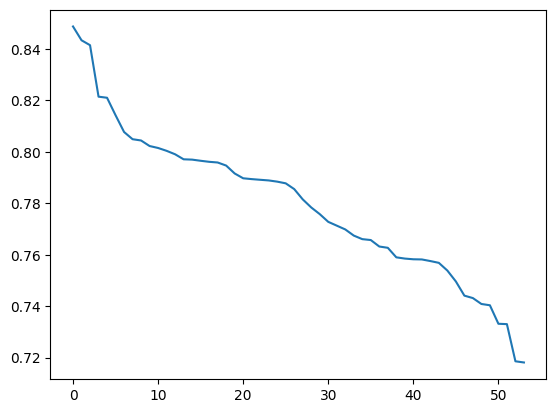

In [389]:
plt.plot(sorted_doc_scores)

## Custom Query Completion

Once our retrieval function is working, we need to:

- Create a prompt or the instruction passed to the LLM with `create_prompt()`, which injects relevant documents to the prompt,
- and `generate_response()` with the created prompt as input.

In the latter function, the `completions` API from OpenAI is used.

The prompt is an instruction for the generative model where we request to answer the user query using the context of the relevant documents.

### Query Prompt

In [390]:
import tiktoken

def create_prompt(
    question: str,
    events_dicts: list[dict],
    sorted_doc_ids: np.ndarray,
    sorted_doc_distances: np.ndarray,
    max_token_count: int
) -> tuple[str, list[int], list[float]]:
    """
    Given a question and a dataframe containing rows of text and their
    embeddings, return a text prompt to send to a Completion model
    """
    # Create a tokenizer that is designed to align with our embeddings
    # Tiktoken is the official tokenizer for OpenAI models
    # GPT-4, GPT-3.5, text-embedding-ada-002 use the same tokenizer: cl100k_base
    tokenizer = tiktoken.get_encoding("cl100k_base")
    
    # Count the number of tokens in the prompt template and question
    prompt_template = """
Answer the question based on the context below, and if the question
can't be answered based on the context, say "I don't know"

Context: 

{}

---

Question: {}
Answer:"""
    
    current_token_count = len(tokenizer.encode(prompt_template)) + \
                            len(tokenizer.encode(question))
    
    context = []
    selected_doc_ids = []
    selected_doc_distances = []
    for doc_id, distance in zip(sorted_doc_ids, sorted_doc_distances):
        # Increase the counter based on the number of tokens in this row
        text = events_dicts[doc_id]["text"]
        text_token_count = len(tokenizer.encode(text))
        current_token_count += text_token_count
        # Add the row of text to the list if we haven't exceeded the max
        if current_token_count <= max_token_count:
            context.append(text)
            selected_doc_ids.append(int(doc_id))
            selected_doc_distances.append(float(distance))
        else:
            break

    return prompt_template.format("\n\n###\n\n".join(context), question), selected_doc_ids, selected_doc_distances

In [394]:
# Retrieve sorted relevant doc ids
question="When was the first election in Spain in the year 2024 and where was it?"
sorted_doc_ids, sorted_doc_scores = find_relevant_docs(question, docs_embeddings)

# Create prompt
prompt, selected_doc_ids, sorted_doc_scores = create_prompt(
    question,
    docs,
    sorted_doc_ids,
    sorted_doc_scores,
    max_token_count=1000,
)

In [396]:
print(prompt)


Answer the question based on the context below, and if the question
can't be answered based on the context, say "I don't know"

Context: 

Date: 18 February. Event: 2024 Galician regional election. Event context: Alfonso Rueda PP Alfonso Rueda PP A regional election was held in Galicia on Sunday, 18 February 2024, to elect the 12th Parliament of the autonomous community . All 75 seats in the Parliament were up for election. The Parliament of Galicia was the devolved , unicameral legislature of the autonomous community of Galicia , having legislative power in regional matters as defined by the Spanish Constitution and the Galician Statute of Autonomy , as well as the ability to vote confidence in or withdraw it from a regional president . [ 1 ] Voting for the Parliament was on the basis of universal suffrage , which comprised all nationals over 18 years of age, registered in Galicia and in full enjoyment of their political rights. Amendments to the electoral law in 2022 abolished the "

In [397]:
print("Relevant document IDs:", selected_doc_ids)
print("Scores:", sorted_doc_scores)

Relevant document IDs: [4, 8, 22, 11, 7]
Scores: [0.8486791398170681, 0.8433168291700441, 0.8414102878895945, 0.8214053854159378, 0.8209808159916119]


### Query Answering Function

The function `ask_question()` is the entrypoint for the user query; there:

- the relevant documents are found,
- the prompt is created,
- and the answer is generated.

In addition, we attach the reference URLs of the retrieved documents to increase transparency.

In [398]:
def generate_response(
    prompt: str,
    generative_model_name: str = "gpt-3.5-turbo-instruct",
    openai_client: openai.OpenAI = openai_client,
    max_answer_tokens: int = 150
):
    """
    Given a question, a dataframe containing rows of text, and a maximum
    number of desired tokens in the prompt and response, return the
    answer to the question according to an OpenAI Completion model
    
    If the model produces an error, return an empty string
    """
    try:
        response = openai_client.completions.create(
            model=generative_model_name,
            prompt=prompt,
            max_tokens=max_answer_tokens,
            temperature=0.7  # optional: defaults to 1.0
        )
        return response.choices[0].text.strip()
    except Exception as e:
        print(f"Error during completion: {e}")
        return ""

def ask_question(
    question: str,
    docs: list[dict],
    docs_embeddings: np.ndarray,
    use_knowledge_base: bool = True,
    max_prompt_tokens: int = 1800,
    max_answer_tokens: int = 150,
):
    if use_knowledge_base:
        # Retrieve sorted relevant doc ids
        sorted_doc_ids, sorted_doc_scores = find_relevant_docs(question, docs_embeddings)

        # Create prompt
        prompt, _, _ = create_prompt(
            question,
            docs,
            sorted_doc_ids,
            sorted_doc_scores,
            max_token_count=max_prompt_tokens,
        )
    else:
        prompt = f"Answer the question:\n\n{question}\n\nAnswer:"
    
    # Generate response / Call completions model
    answer = generate_response(
        prompt=prompt,
        max_answer_tokens=max_answer_tokens
    )
    
    if use_knowledge_base:
        max_references = 2
        ref_urls = []
        for i in sorted_doc_ids[:max_references]:
            if docs[i]["reference_urls"]:
                ref_urls.extend(docs[i]["reference_urls"])
        answer += "\n\nReference(s):\n" + "\n".join(ref_urls) + ""

    return answer

In [399]:
question = "When was the first election in Spain in the year 2024 and where was it?"
response = ask_question(question, docs, docs_embeddings, use_knowledge_base=True)
print(response)

The first election in Spain in the year 2024 was held in the Basque Country on Sunday, 21 April 2024.

Reference(s):
https://en.wikipedia.org/wiki/2024_Galician_regional_election
https://en.wikipedia.org/wiki/2024_Basque_regional_election


## Custom Performance Demonstration

The employed generative **model** [`gpt-3.5-turbo-instruct`](https://platform.openai.com/docs/models/gpt-3.5-turbo?snapshot=gpt-3.5-turbo-instruct) was trained with data up to September 2021.
Therefore, it should not have been exposed to any of the 2024 events in Spain.

In the following, we run `ask_question()` with two different values of the flag argument `use_knowledge_base`:

- `use_knowledge_base=True`: the RAG pattern is used, i.e., the relevant documents aligned with the question are passed to the model and it successfully answers the question.
- `use_knowledge_base=False`: none of the documents is passed to the model, so it fails to answer properly.

### Question 1

### Question 2